In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = "third" # "second" "third"
path = "./second_dataset/mbti_1.csv"
seed = 0
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
# Data
train_fraction = 0.80
val_fraction = 0.10
vocab_size = 20000
seq_len = 256 
vocab = "vocab"
preset_token = ["__pad__", "__url__", "__sep__", "__tar__", "__unk__"]
token_col = "tokens"
target_cols = ["I_E", "N_S", "T_F", "J_P"]
pad_id = 0
targets = 4

# Model
cfg_embed_dim = 384 # (128, 256, 384, 512) 
cfg_hidden_dim = 384 # (128, 256, 384, 512)
cfg_num_layers = 1 # (1, 2, 3)
cfg_dropout = 0.3 # 0.2-0.5
cfg_bidirectional = False

# Train
cfg_batch_size = 64 # (64, 128, 256)
cfg_lr = 1e-3        # (5e-5, 1e-4, 5e-4, 1e-3) 
cfg_weight_decay = 1e-4 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
cfg_epochs = 20
cfg_max_grad_norm = 0.5 # (0.5–2.0)

cfg_thresholds = [0.5]*4 #[0.44, 0.31, 0.6, 0.96], best thresholds rely on model

if dataset == "third":#
    path = "./third_dataset/MBTI 500.csv"
    # Model
    cfg_embed_dim = 384 # (128, 256, 384, 512) 
    cfg_hidden_dim = 384 # (128, 256, 384, 512)
    cfg_num_layers = 1 # (1, 2, 3)
    cfg_dropout = 0.3 # 0.2-0.5
    cfg_bidirectional = False

    # Train
    cfg_batch_size = 64 # (64, 128, 256)
    cfg_lr = 1e-3        # (5e-5, 1e-4, 5e-4, 1e-3) 
    cfg_weight_decay = 1e-4 # (5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2)
    cfg_max_grad_norm = 0.5 # (0.5–2.0)


In [43]:
# Data curation
import regex
def preprocess_df(df):
    posts = df["posts"]
    types = df["type"]
    
    posts = posts.replace(r"http[^\s|]+", " __url__ ", regex=True)
    posts = posts.str.replace("|||", " __sep__ ", regex=False)
    posts = posts.replace(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", regex=True) # i.e. INTP, ENFJ
    posts = posts.replace(r"\s+", " ", regex=True) # remove excess spaces
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}5\p{Nd}\p{Emoji}]+") # remove everything that is not _, " ", latin, or emojis
    posts = posts.apply(lambda s: rx.sub("", s))
    
    types = types.replace(r"I|N|T|J", "1", regex=True)
    types = types.replace(r"E|S|F|P", "0", regex=True)
    
    df["posts"] = posts
    df["type"] = types
    
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    df[["I_E", "N_S", "T_F", "J_P"]] = (
        df["type"].apply(lambda s: pd.Series([int(c) for c in s]))
    ).astype("int32")

    return df

In [44]:
# cut off data to balance distribution
import pandas as pd

def equal_dist_sample(df, total_n=10_000, seed=seed) -> pd.DataFrame:
    counts = df["type"].value_counts()
    amt_classes = len(counts)
    amt_per_class = total_n // amt_classes
    need = pd.Series(amt_per_class, index=counts.index)
    out = need.clip(upper=counts)
    


    parts = [
        df[df["type"] == cls].sample(n=int(out[cls]), random_state=seed)
        for cls in out.index
        if int(out[cls]) > 0
    ]
    out = pd.concat(parts, ignore_index=True).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out
df = pd.read_csv(path)
df_preview = equal_dist_sample(df)
counts = df_preview["type"].value_counts()
print(counts)
print(sum(counts.values))


type
ESTP    625
ISFJ    625
ENTP    625
INFP    625
INTJ    625
INTP    625
INFJ    625
ISTJ    625
ISTP    625
ISFP    625
ENTJ    625
ENFJ    625
ENFP    625
ESTJ    482
ESFP    360
ESFJ    181
Name: count, dtype: int64
9148


In [45]:
# train/test split
torch.manual_seed = seed
df = pd.read_csv(path)
df = preprocess_df(df)
if dataset == "third":
    df = equal_dist_sample(df)
print(df)
n = len(df)
n_train = int(train_fraction * n)
n_val = int((val_fraction + train_fraction) * n)

train_df = df[ : n_train]
val_df = df[n_train : n_val]
test_df = df[n_val : ]

                                                  posts  type  I_E  N_S  T_F  \
0     intention part visitor create pleasant feel at...  0010    0    0    1   
1     like enfps enfps welcome __tar__ bizarrely eno...  1001    1    0    0   
2     microwave anyway would say necessarily need th...  0110    0    1    1   
3     kind personality type test online quiz come sp...  1100    1    1    0   
4     lovli når antifascisterne mere eller mindre st...  0011    0    0    1   
...                                                 ...   ...  ...  ...  ...   
9143  opposite song select find interest general pop...  1010    1    0    1   
9144  also idk specific __tar__ hat need touch head ...  1001    1    0    0   
9145  muiple monopoly kid much age difference kid hu...  0111    0    1    1   
9146  usually get answer sound like really round way...  0100    0    1    0   
9147  eventually meet person prove trust right choic...  0110    0    1    1   

      J_P  
0       0  
1       1  
2  

In [46]:
# Tokenizing function

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.normalizers import BertNormalizer
from tokenizers.pre_tokenizers import BertPreTokenizer
from pathlib import Path


def tokenize():
    tok = Tokenizer(WordPiece(unk_token="__unk__"))
    tok.normalizer = BertNormalizer(lowercase=True)
    tok.pre_tokenizer = BertPreTokenizer()

    trainer = WordPieceTrainer(vocab_size=vocab_size, special_tokens=preset_token)
    tok.train_from_iterator(train_df["posts"], trainer=trainer)

    tok.save(str(Path(path).parent / "tokenizer.json"))
    print("saved at:", str(Path(path).parent / "tokenizer.json"))
    return tok




In [47]:
# tokenizer
if dataset == "third":
    tok = tokenize()
else:
    try:
        tok = Tokenizer.from_file(str(Path(path).parent / "tokenizer.json"))
    except:
        print("creating new Tokenizer")
        tok = tokenize()

pad_id = tok.token_to_id("__pad__")
tok.enable_padding(length=seq_len, pad_id=pad_id, pad_token="__pad__")
tok.enable_truncation(max_length=seq_len)

def add_input_ids(df, tok, text_col="posts", out_col=token_col):
    encs = tok.encode_batch(df[text_col].astype(str).tolist())
    df = df.copy()
    df[out_col] = [e.ids for e in encs]
    return df

train_df = add_input_ids(train_df, tok, text_col="posts", out_col=token_col)
val_df   = add_input_ids(val_df,   tok, text_col="posts", out_col=token_col)
test_df  = add_input_ids(test_df,  tok, text_col="posts", out_col=token_col)

y_train = train_df[target_cols].to_numpy(dtype=np.int32)
y_val = val_df[target_cols].to_numpy(dtype=np.int32)
y_test  = test_df[target_cols].to_numpy(dtype=np.int32)


saved at: third_dataset\tokenizer.json


In [48]:
def near_exact_match(y_true, y_pred, min_correct=3):
    correct_per_sample = (y_pred == y_true).sum(axis=1)
    return (correct_per_sample >= min_correct).mean()

In [49]:
# Majority Guessing baseline 

def majority_guessing(y_true):
    priors = y_true.mean(axis=0)
    majority_bits = (priors >= 0.5).astype(np.int32)
    y_pred = np.tile(majority_bits, (len(y_true), 1))
    
    nem = near_exact_match(y_true, y_pred)
    per_label_acc = (y_true == y_pred).mean(axis=0)
    h_loss = hamming_loss(y_true, y_pred)

    per_label_f1 = [f1_score(y_true[:, j], y_pred[:, j],
                        average="macro", zero_division=0)
                for j in range(y_true.shape[1])]
    f1 = float(np.mean(per_label_f1))

    print("Near Exact match:", nem)
    print("Hamming loss:", h_loss)
    print("MacroF1:", f1), 
    print("per label F1:", per_label_f1)
    print("per label acc:", per_label_acc)

majority_guessing(y_train)

Near Exact match: 0.34244329051653455
Hamming loss: 0.46348045914184205
MacroF1: 0.3491260320477214
per label F1: [0.35319073713982674, 0.35495813133539006, 0.34852666251224074, 0.33982859720342806]
per label acc: [0.54605083 0.55028696 0.53498224 0.51475813]


In [50]:
# balanced ce loss function
# class weights
eps = 1e-4
ce_pos_rate = np.clip(y_train.mean(axis=0), eps, 1-eps)  # pos_rate je Dimension

w0 = 0.5 / (1 - ce_pos_rate)
w1 = 0.5 / ce_pos_rate

class_weights = []
for target in range(targets):
    class_weights.append(torch.tensor([w0[target], w1[target]], dtype=torch.float32, device=device))
    
def balanced_ce_loss(logits, y, class_weights=class_weights):
    loss = 0.0
    for target in range(targets):
        loss = loss + nn.functional.cross_entropy(logits[:, target, :], y[:, target], weight=class_weights[target])
    return loss / targets

In [51]:
# model class
class LSTM_MBTI(nn.Module):
    def __init__(self, embed_dim=cfg_embed_dim, hidden_dim=cfg_hidden_dim, num_layers=cfg_num_layers, dropout=cfg_dropout, bidirectional=cfg_bidirectional):
        super().__init__()
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_id
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, 8)
        )

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        out, _ = self.lstm(x)

        mask = (input_ids != pad_id).to(out.dtype)
        denom = mask.sum(dim=1, keepdim=True).clamp(min=1.0)
        pooled = (out * mask.unsqueeze(-1)).sum(dim=1) / denom

        return self.head(pooled).view(-1, 4, 2)


In [52]:
# dataset
from torch.utils.data import TensorDataset
def make_ds(df):
    x = torch.tensor(np.stack(df[token_col].to_list()), dtype=torch.long)
    y = torch.tensor(df[target_cols].to_numpy(np.float32), dtype=torch.float32)
    return TensorDataset(x, y)

In [53]:
# data loaders
train_ds = make_ds(train_df)
val_ds   = make_ds(val_df)
test_ds   = make_ds(test_df)

cfg_train_loader = DataLoader(train_ds, batch_size=cfg_batch_size, shuffle=True, num_workers=0,
                        pin_memory=torch.cuda.is_available())
cfg_val_loader = DataLoader(val_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
cfg_test_loader = DataLoader(test_ds, batch_size=cfg_batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())

In [59]:
# train and eval
import torch
import torch.nn as nn
import time
import copy
from tqdm.auto import tqdm
from IPython.display import display, update_display
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import deque



@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    y_true_all = []
    y_pred_all = []
    probs_all = []

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        logits = model(x)

        
        loss = balanced_ce_loss(logits, y)
        losses.append(loss.item())

        probs = torch.softmax(logits, dim=-1).cpu().numpy()
        y_true = y.cpu().numpy().astype(np.int32)
        
        y_pred = probs.argmax(-1).astype(np.int32)

        y_true_all.append(y_true)
        y_pred_all.append(y_pred)
        probs_all.append(probs)

    
    
    y_true_all = np.vstack(y_true_all)
    y_pred_all = np.vstack(y_pred_all)
    probs_all = np.vstack(probs_all)
    
    N = y_true_all.shape[0]
    idx = np.arange(N)

    # y for 8 logits
    y_true = np.zeros((N, 8), dtype=np.int32)
    y_pred = np.zeros((N, 8), dtype=np.int32)

    probs = np.zeros((N, 8), dtype=np.float32)

    for j in range(4):
        y_true[idx, 2*j + y_true_all[:, j]] = 1
        y_pred[idx, 2*j + y_pred_all[:, j]] = 1

        probs[:, 2*j + 0] = probs_all[:, j, 0]
        probs[:, 2*j + 1] = probs_all[:, j, 1]

    
    per_label_f1 = []
    per_label_ap = []
    for j in range(8):
        f1_j = f1_score(y_true[:, j], y_pred[:, j], average="binary", zero_division=0)
        ap_j = average_precision_score(y_true[:, j], probs[:, j])
        per_label_f1.append(f1_j)
        per_label_ap.append(ap_j)


    # sklearn:
    nem = near_exact_match(y_true_all, y_pred_all)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    macro_ap = np.mean(per_label_ap)
    ham = hamming_loss(y_true_all, y_pred_all)
    
    
    return {
        "loss": float(np.mean(losses)),
        "hamming_loss": float(ham),
        "nem": float(nem),
        "microF1": float(micro),
        "macroF1": float(macro),
        "macroAP": float(macro_ap),
        "per_label_f1": per_label_f1,
    }

def train(model, epochs=cfg_epochs, lr=cfg_lr, weight_decay=cfg_weight_decay, max_grad_norm=cfg_max_grad_norm,
        train_loader=cfg_train_loader, val_loader=cfg_val_loader, output=True, save_all_epochs=False):
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",
        factor=0.5,
        patience=2,
        threshold=5e-3,
        threshold_mode="rel"
    )
    
    history = {
        "nem": [],
        "train_loss": [],
        "val_loss": [],
        "val_macroF1": [],
        "val_macroAP": [],
    }

    chosen_f1 = -np.inf
    best_state = None
    earliest_epoch=3 #also adjusts window size
    f1_window = deque(maxlen=earliest_epoch)
    f1_window_means = [np.nan]*earliest_epoch
    f1_window_stds = [np.nan]*earliest_epoch
    state_epoch = 0
    val_display_id = "val_details"
    display("", display_id=val_display_id)
    pbar = tqdm(total=epochs)
    smoothed_best = -np.inf
    best_state = None
    states = [None]*earliest_epoch
    for epoch in range(1, epochs + 1):
        start = time.perf_counter()
        model.train()
        running = 0.0
        n_batches = 0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            

            loss = balanced_ce_loss(logits, y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            running += loss.item()
            n_batches += 1

        epoch_time = time.perf_counter() - start
        val = evaluate(model, val_loader)
        
        scheduler.step(val["macroAP"])
        
        train_loss_epoch = running / max(n_batches, 1)
        history["nem"].append(float(val["nem"]))
        history["train_loss"].append(float(train_loss_epoch))
        history["val_loss"].append(float(val["loss"]))
        history["val_macroF1"].append(float(val["macroF1"]))
        history["val_macroAP"].append(float(val["macroAP"]))
        pbar.set_description(f"Epoch {epoch}/{epochs}")
        if output:
            val_text = (f"VAL  loss={val['loss']:.3f} nem={val['nem']:.3f} hamming_loss={val['hamming_loss']:.3f} "
            f"microF1={val['microF1']:.3f} macroF1={val['macroF1']:.3f} "
            f"per_label_f1={np.round(val['per_label_f1'], 3)}")
            update_display(val_text, display_id=val_display_id)
        else:
            print(f"macroF1={val["macroF1"]:.3f}")
            print(f"epoch_time={epoch_time:.2f}s")


        delta = 1e-2
        val_f1 = val["macroF1"]
        
        f1_window.append(val_f1)
        
        
        
        if epoch > earliest_epoch:
            smoothed = sum(f1_window) / len(f1_window)
            f1_window_means.append(np.mean(f1_window))
            f1_window_stds.append(np.std(f1_window))
            if save_all_epochs:
                states.append(copy.deepcopy(model.state_dict()))
            elif smoothed > smoothed_best + delta:
                smoothed_best = smoothed
                best_state = copy.deepcopy(model.state_dict())
                state_epoch = epoch
                chosen_f1 = val_f1
            
        pbar.set_postfix_str(f"macroF1={val['macroF1']:.3f} epoch_time={epoch_time:.2f}s")
        pbar.update(1)
        
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"loaded model from epoch {state_epoch}")
        
    
    epochs_r = range(1, len(history["train_loss"]) + 1)
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    means = np.asarray(f1_window_means)
    stds = np.asarray(f1_window_stds)
    ax1.plot(epochs_r, history["val_macroF1"],  "b", label="val_macroF1")
    ax1.plot(epochs_r, history["val_macroAP"], "g", label="val_macroAP")
    ax1.plot(epochs_r, f1_window_means, "y", linestyle="dotted", label="f1 mean")
    ax1.fill_between(epochs_r, means - stds, means + stds, alpha=0.2, label="std")
    ax2.plot(epochs_r, history["nem"],  "r", label="nem")
    ax1.set_ylim(0.5, 0.8)
    ax1.set_ylabel("Score")
    ax1.set_xlim(1, len(epochs_r))
    ax1.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax1.grid(True, axis='x', which='major', linestyle='-', alpha=0.3)
    ax2.set_ylabel("nem Match")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()
    return model, chosen_f1, states


Tuning

batch_size=64, with learning rate=0.0001


'VAL  loss=0.719 nem=0.619 hamming_loss=0.317 microF1=0.683 macroF1=0.680 per_label_f1=[0.583 0.691 0.698 0.734 0.731 0.756 0.615 0.632]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


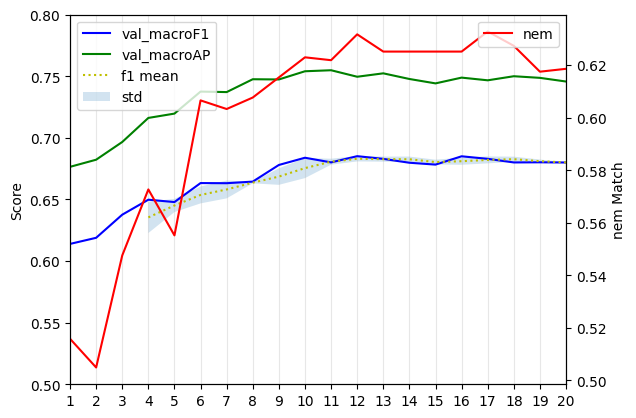

best_score_this_training=0.680 max_score=0.680 current best lr=0.0001 current best batch size=64
batch_size=64, with learning rate=0.0005


'VAL  loss=1.696 nem=0.627 hamming_loss=0.307 microF1=0.693 macroF1=0.692 per_label_f1=[0.627 0.699 0.701 0.732 0.704 0.737 0.683 0.653]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


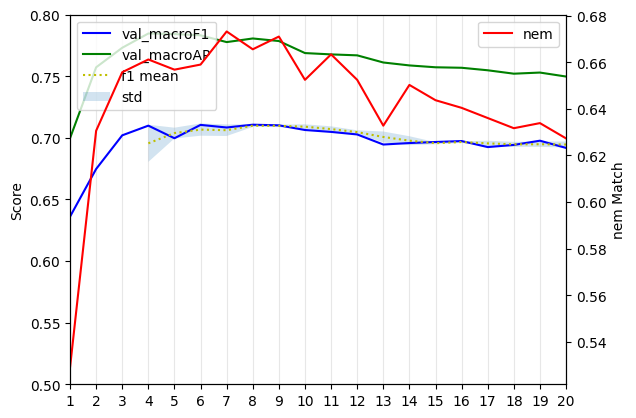

best_score_this_training=0.711 max_score=0.711 current best lr=0.0005 current best batch size=64
batch_size=64, with learning rate=0.001


'VAL  loss=1.712 nem=0.655 hamming_loss=0.290 microF1=0.710 macroF1=0.708 per_label_f1=[0.619 0.705 0.697 0.725 0.723 0.756 0.731 0.706]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


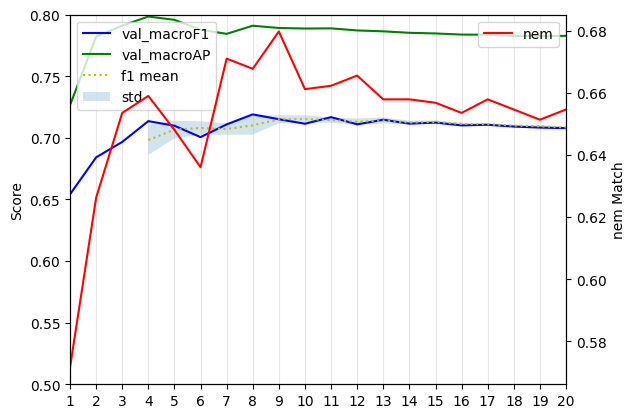

best_score_this_training=0.719 max_score=0.719 current best lr=0.001 current best batch size=64
batch_size=128, with learning rate=0.0001


'VAL  loss=0.685 nem=0.611 hamming_loss=0.316 microF1=0.684 macroF1=0.676 per_label_f1=[0.514 0.728 0.713 0.737 0.702 0.738 0.625 0.653]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 16


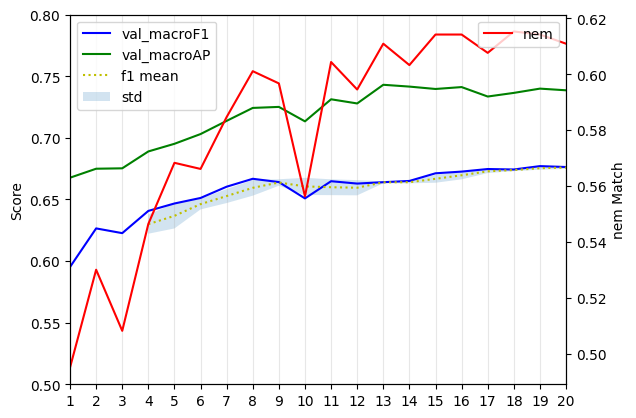

best_score_this_training=0.673 max_score=0.719 current best lr=0.001 current best batch size=64
batch_size=128, with learning rate=0.0005


'VAL  loss=1.151 nem=0.640 hamming_loss=0.303 microF1=0.697 macroF1=0.696 per_label_f1=[0.631 0.705 0.691 0.714 0.729 0.76  0.677 0.658]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 5


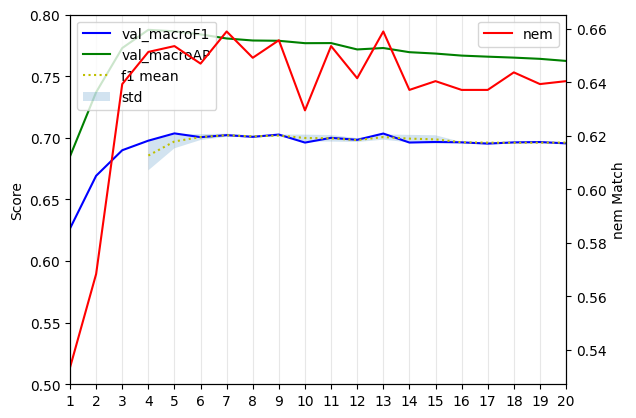

best_score_this_training=0.704 max_score=0.719 current best lr=0.001 current best batch size=64
batch_size=128, with learning rate=0.001


'VAL  loss=1.593 nem=0.620 hamming_loss=0.304 microF1=0.696 macroF1=0.693 per_label_f1=[0.645 0.731 0.686 0.718 0.707 0.744 0.677 0.639]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 4


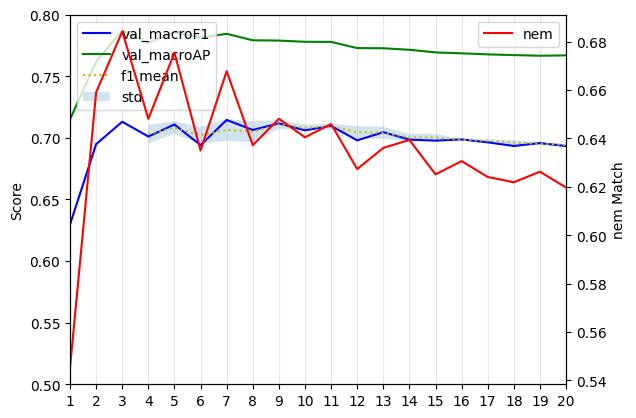

best_score_this_training=0.701 max_score=0.719 current best lr=0.001 current best batch size=64
batch_size=256, with learning rate=0.0001


'VAL  loss=0.649 nem=0.595 hamming_loss=0.327 microF1=0.673 macroF1=0.667 per_label_f1=[0.55  0.713 0.69  0.724 0.717 0.738 0.572 0.636]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 20


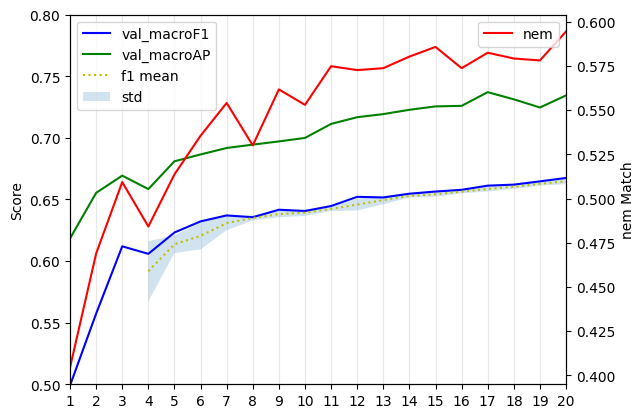

best_score_this_training=0.667 max_score=0.719 current best lr=0.001 current best batch size=64
batch_size=256, with learning rate=0.0005


'VAL  loss=1.062 nem=0.627 hamming_loss=0.307 microF1=0.693 macroF1=0.690 per_label_f1=[0.627 0.723 0.658 0.681 0.713 0.755 0.694 0.671]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


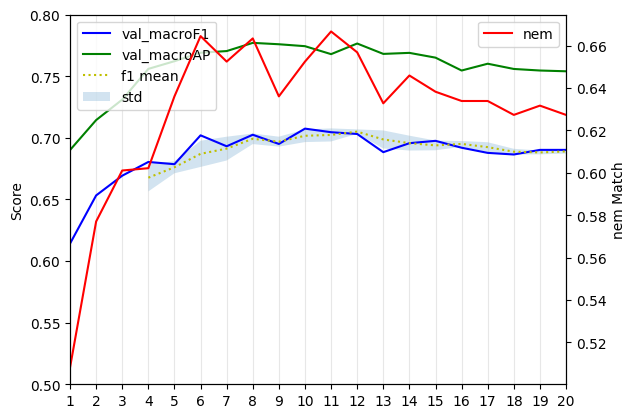

best_score_this_training=0.703 max_score=0.719 current best lr=0.001 current best batch size=64
batch_size=256, with learning rate=0.001


'VAL  loss=1.370 nem=0.630 hamming_loss=0.303 microF1=0.697 macroF1=0.695 per_label_f1=[0.638 0.715 0.688 0.718 0.718 0.753 0.679 0.653]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 5


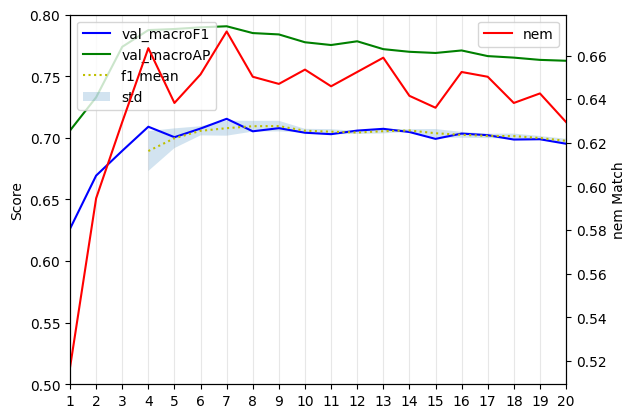

best_score_this_training=0.701 max_score=0.719 current best lr=0.001 current best batch size=64


In [60]:
# tune batch_size and learning rate
iterate_batch_size = [64, 128, 256]
iterate_lr = [1e-4, 5e-4, 1e-3]
max_val  = -np.inf
best_batch_size = -np.inf
best_lr = -np.inf
for batch_size in iterate_batch_size:
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                        pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                        pin_memory=torch.cuda.is_available())
    
    for lr in iterate_lr:
        model = LSTM_MBTI()
        print(f"\033[31mbatch_size={batch_size}, with learning rate={lr}\033[0m")
        model, best_score, _ = train(model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=lr
        )
        if best_score > max_val:
                max_val = best_score
                best_batch_size = batch_size
                best_lr = lr
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best lr={best_lr} current best batch size={best_batch_size}\033[0m")

weight decay=1e-05


'VAL  loss=3.078 exact=0.248 hamming_loss=0.308 microF1=0.692 macroF1=0.573 per_label_f1=[0.285 0.819 0.168 0.897 0.7   0.617 0.659 0.443]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


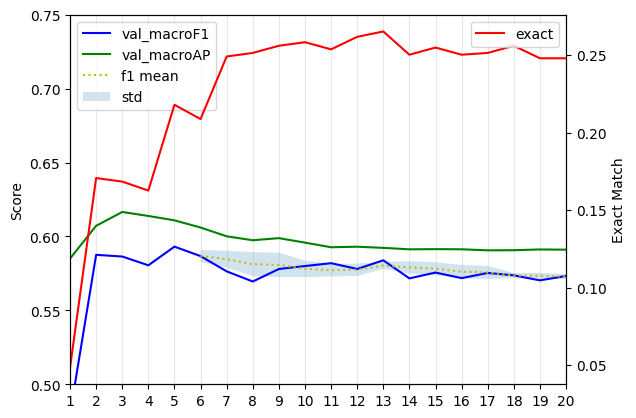

best_score_this_training=0.587 max_score=0.587 current best weight_decay=1e-05
weight decay=5e-05


'VAL  loss=2.966 exact=0.236 hamming_loss=0.304 microF1=0.696 macroF1=0.582 per_label_f1=[0.322 0.819 0.176 0.897 0.712 0.644 0.658 0.424]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


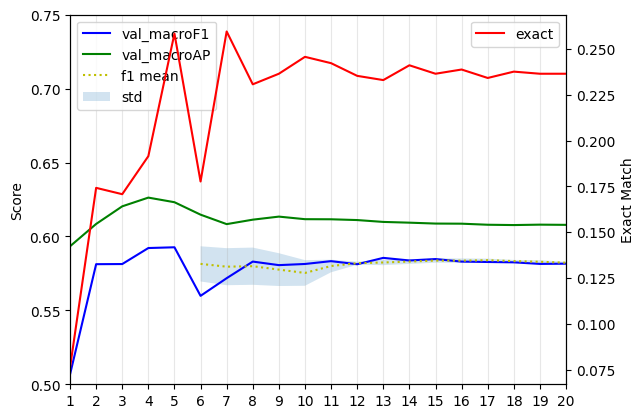

best_score_this_training=0.560 max_score=0.587 current best weight_decay=1e-05
weight decay=0.0001


'VAL  loss=3.007 exact=0.256 hamming_loss=0.299 microF1=0.701 macroF1=0.586 per_label_f1=[0.317 0.825 0.197 0.899 0.707 0.616 0.677 0.445]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


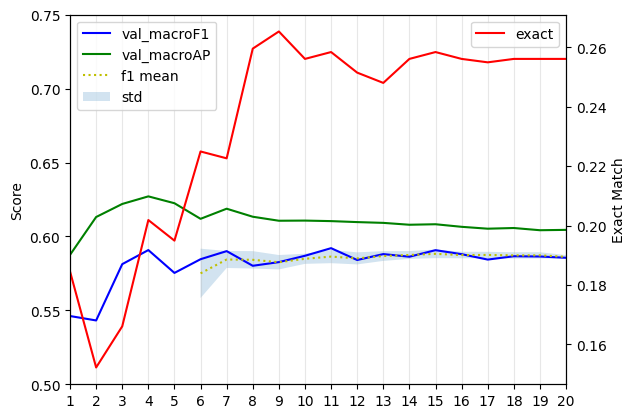

best_score_this_training=0.592 max_score=0.592 current best weight_decay=0.0001
weight decay=0.0005


'VAL  loss=2.848 exact=0.253 hamming_loss=0.303 microF1=0.697 macroF1=0.573 per_label_f1=[0.249 0.813 0.147 0.903 0.701 0.638 0.664 0.468]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


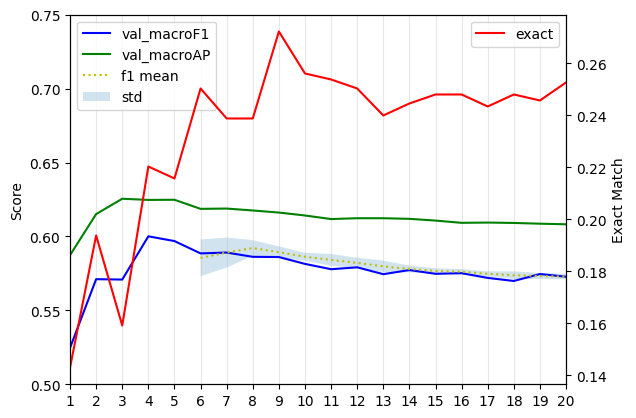

best_score_this_training=0.589 max_score=0.592 current best weight_decay=0.0001
weight decay=0.001


'VAL  loss=3.051 exact=0.224 hamming_loss=0.307 microF1=0.693 macroF1=0.575 per_label_f1=[0.283 0.83  0.198 0.9   0.695 0.609 0.645 0.44 ]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


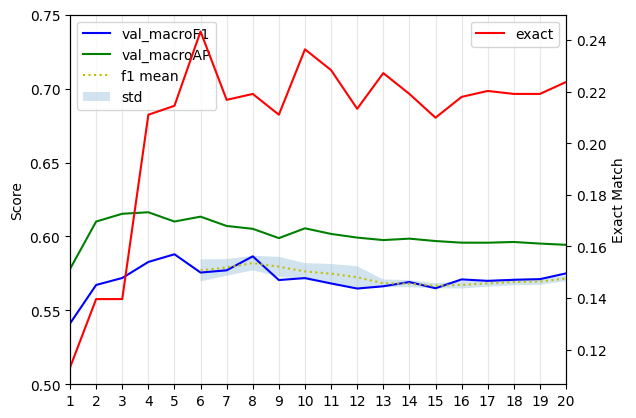

best_score_this_training=0.576 max_score=0.592 current best weight_decay=0.0001
weight decay=0.005


'VAL  loss=3.133 exact=0.219 hamming_loss=0.311 microF1=0.689 macroF1=0.575 per_label_f1=[0.299 0.828 0.237 0.904 0.695 0.603 0.633 0.403]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


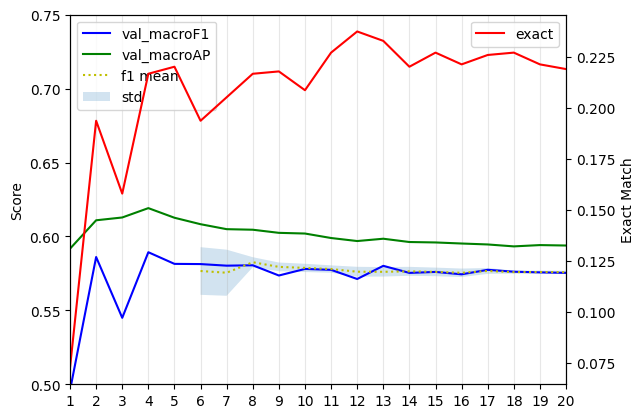

best_score_this_training=0.581 max_score=0.592 current best weight_decay=0.0001
weight decay=0.01


'VAL  loss=2.898 exact=0.248 hamming_loss=0.307 microF1=0.693 macroF1=0.579 per_label_f1=[0.264 0.815 0.232 0.901 0.711 0.634 0.653 0.419]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


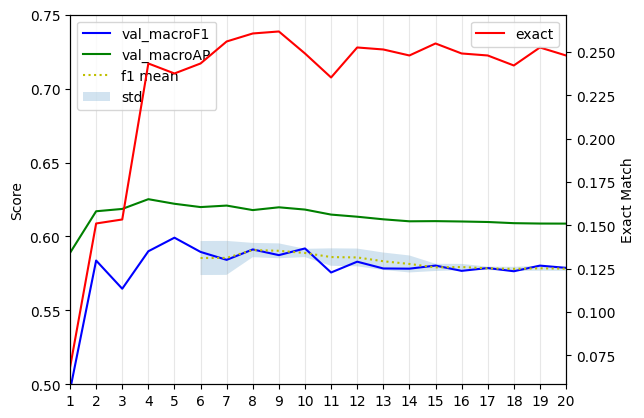

best_score_this_training=0.590 max_score=0.592 current best weight_decay=0.0001


In [38]:
# tune weight_decay
iterate_weight_decay = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
max_val  = -np.inf
best_weight_decay = -np.inf
for weight_decay in iterate_weight_decay:
        model = LSTM_MBTI()
        print(f"\033[31mweight decay={weight_decay}\033[0m")
        model, best_score, _ = train(model, weight_decay=weight_decay, output=True)
        if best_score > max_val:
                max_val = best_score
                best_weight_decay = weight_decay
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best weight_decay={best_weight_decay}\033[0m")

dropout=0.2


'VAL  loss=3.096 exact=0.230 hamming_loss=0.307 microF1=0.693 macroF1=0.580 per_label_f1=[0.295 0.811 0.197 0.899 0.693 0.629 0.664 0.454]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


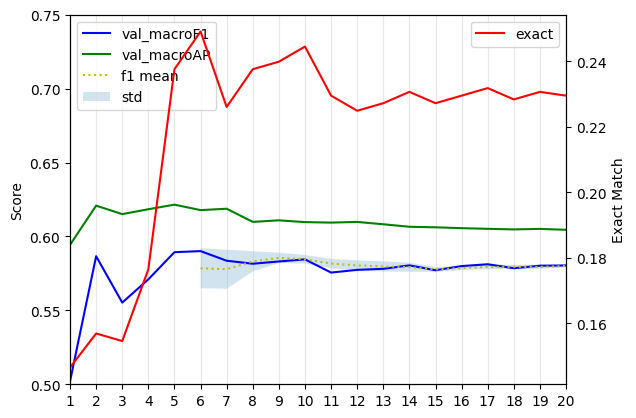

best_score_this_training=0.590 max_score=0.590 current best dropout=0.2
dropout=0.3


'VAL  loss=2.993 exact=0.238 hamming_loss=0.305 microF1=0.695 macroF1=0.577 per_label_f1=[0.292 0.817 0.152 0.891 0.71  0.63  0.67  0.457]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


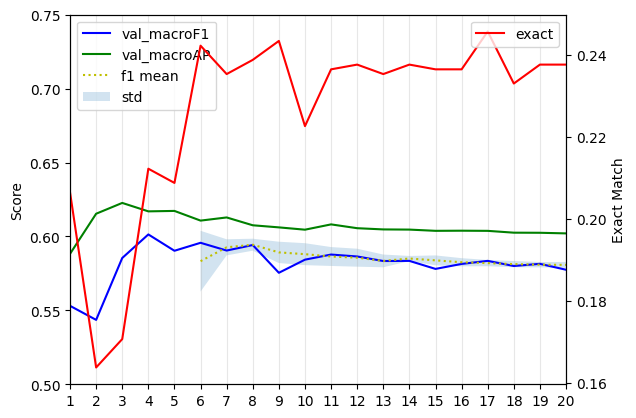

best_score_this_training=0.594 max_score=0.594 current best dropout=0.3
dropout=0.4


'VAL  loss=2.962 exact=0.241 hamming_loss=0.305 microF1=0.695 macroF1=0.586 per_label_f1=[0.318 0.814 0.226 0.902 0.699 0.627 0.662 0.441]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


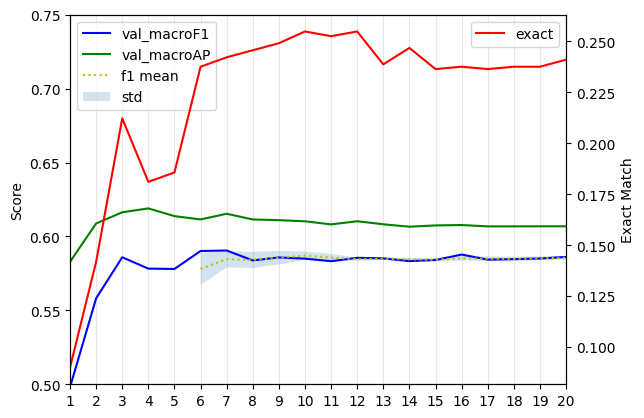

best_score_this_training=0.590 max_score=0.594 current best dropout=0.3
dropout=0.5


'VAL  loss=2.800 exact=0.221 hamming_loss=0.307 microF1=0.693 macroF1=0.584 per_label_f1=[0.259 0.804 0.244 0.899 0.702 0.637 0.664 0.466]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 7


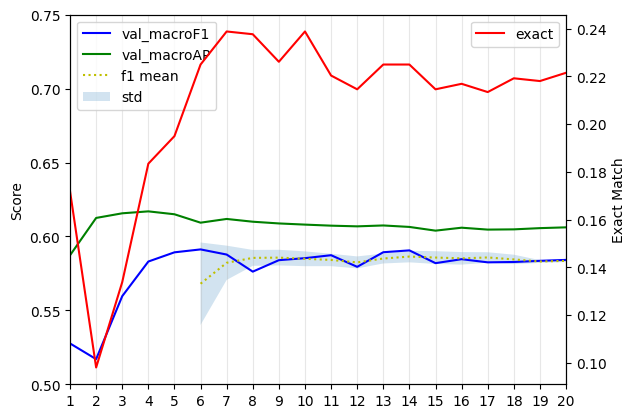

best_score_this_training=0.588 max_score=0.594 current best dropout=0.3


In [52]:
# tune dropout
iterate_dropout = [0.2, 0.3, 0.4, 0.5]
max_val  = -np.inf
best_dropout = -np.inf
for dropout in iterate_dropout:
        model = LSTM_MBTI(dropout=dropout)
        print(f"\033[31mdropout={dropout}\033[0m")
        model, best_score, _ = train(model)
        if best_score > max_val:
                max_val = best_score
                best_dropout = dropout
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best dropout={best_dropout}\033[0m")

max_grad_norm=0.5


'VAL  loss=3.108 exact=0.235 hamming_loss=0.303 microF1=0.697 macroF1=0.580 per_label_f1=[0.282 0.825 0.211 0.898 0.714 0.627 0.664 0.423]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


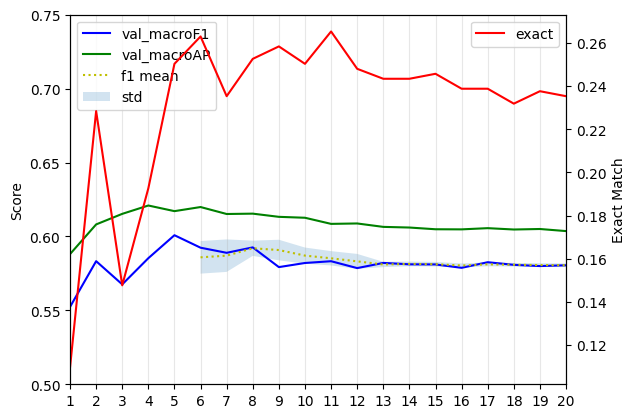

best_score_this_training=0.592 max_score=0.592 current best max_grad_norm=0.5
max_grad_norm=1.0


'VAL  loss=3.051 exact=0.233 hamming_loss=0.302 microF1=0.698 macroF1=0.582 per_label_f1=[0.294 0.819 0.183 0.902 0.715 0.662 0.647 0.437]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


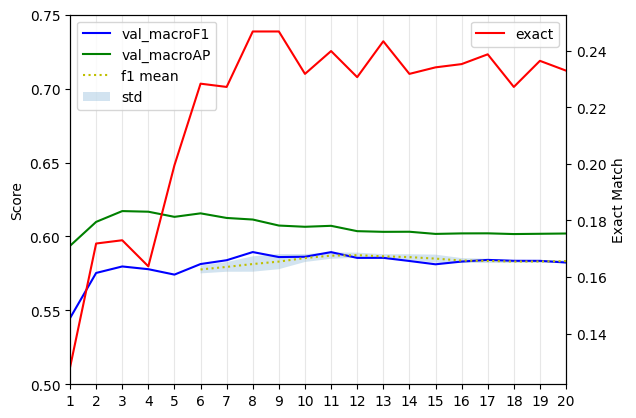

best_score_this_training=0.581 max_score=0.592 current best max_grad_norm=0.5
max_grad_norm=1.5


'VAL  loss=3.194 exact=0.239 hamming_loss=0.306 microF1=0.694 macroF1=0.573 per_label_f1=[0.267 0.828 0.207 0.906 0.707 0.619 0.645 0.409]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


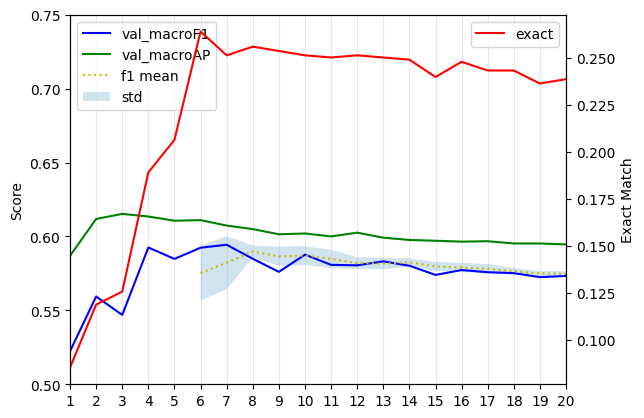

best_score_this_training=0.585 max_score=0.592 current best max_grad_norm=0.5
max_grad_norm=2.0


'VAL  loss=3.078 exact=0.228 hamming_loss=0.305 microF1=0.695 macroF1=0.579 per_label_f1=[0.281 0.823 0.206 0.9   0.716 0.641 0.646 0.418]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


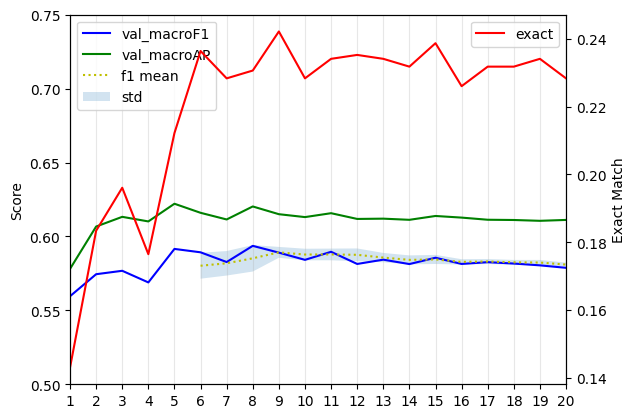

best_score_this_training=0.589 max_score=0.592 current best max_grad_norm=0.5


In [67]:
# tune max_grad_norm
iterate_max_grad_norm = [0.5, 1.0, 1.5, 2.0]
max_val  = -np.inf
best_max_grad_norm = -np.inf
for max_grad_norm in iterate_max_grad_norm:
        model = LSTM_MBTI()
        print(f"\033[31mmax_grad_norm={max_grad_norm}\033[0m")
        model, best_score, _ = train(model, max_grad_norm=max_grad_norm)
        if best_score > max_val:
                max_val = best_score
                best_max_grad_norm = max_grad_norm
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best max_grad_norm={best_max_grad_norm}\033[0m")

hidden_dim=128


'VAL  loss=2.322 exact=0.248 hamming_loss=0.304 microF1=0.696 macroF1=0.573 per_label_f1=[0.272 0.828 0.155 0.901 0.698 0.616 0.648 0.469]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


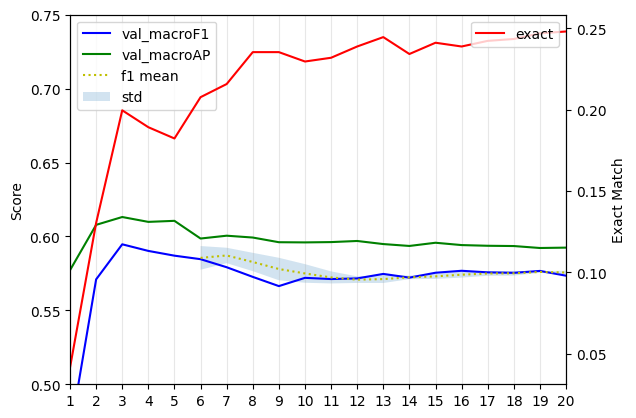

best_score_this_training=0.585 max_score=0.585 current best hidden_dim=128
hidden_dim=256


'VAL  loss=2.921 exact=0.240 hamming_loss=0.300 microF1=0.700 macroF1=0.584 per_label_f1=[0.283 0.826 0.202 0.897 0.725 0.65  0.65  0.438]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 20


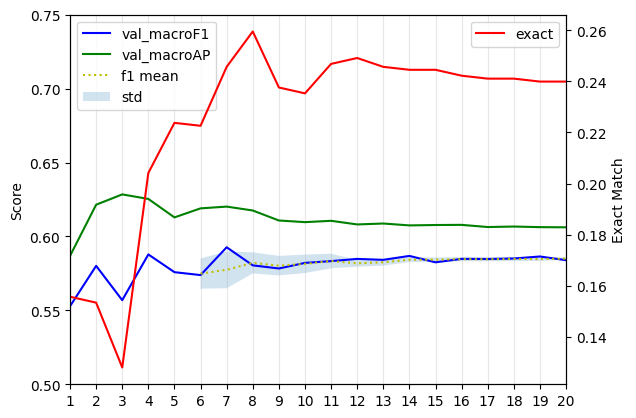

best_score_this_training=0.584 max_score=0.585 current best hidden_dim=128
hidden_dim=384


'VAL  loss=3.027 exact=0.250 hamming_loss=0.291 microF1=0.709 macroF1=0.593 per_label_f1=[0.326 0.829 0.198 0.906 0.716 0.641 0.678 0.45 ]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


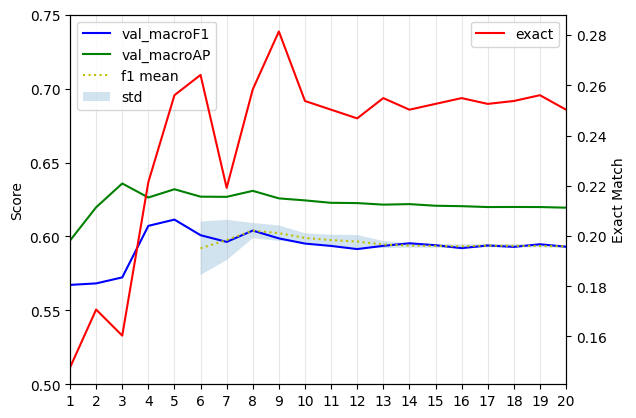

best_score_this_training=0.604 max_score=0.604 current best hidden_dim=384
hidden_dim=512


'VAL  loss=3.218 exact=0.261 hamming_loss=0.288 microF1=0.712 macroF1=0.586 per_label_f1=[0.289 0.827 0.119 0.895 0.725 0.668 0.7   0.465]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


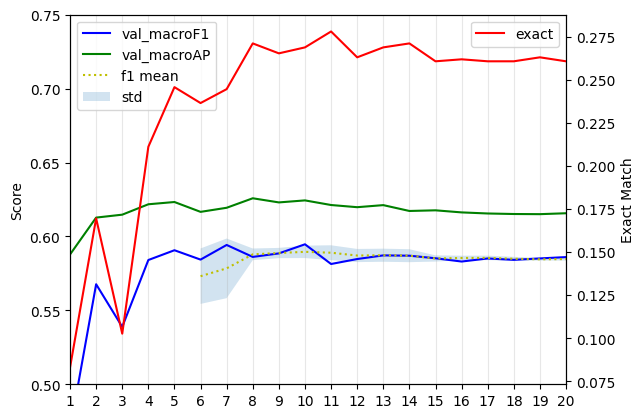

best_score_this_training=0.586 max_score=0.604 current best hidden_dim=384


In [13]:
# tune hidden_dim
iterate_hidden_dim = [128, 256, 384, 512]
max_val  = -np.inf
best_hidden_dim = -np.inf
for hidden_dim in iterate_hidden_dim:
        model = LSTM_MBTI(hidden_dim=hidden_dim)
        print(f"\033[31mhidden_dim={hidden_dim}\033[0m")
        model, best_score, _ = train(model)
        if best_score > max_val:
                max_val = best_score
                best_hidden_dim = hidden_dim
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best hidden_dim={best_hidden_dim}\033[0m")

num layers=1


'VAL  loss=2.931 exact=0.253 hamming_loss=0.295 microF1=0.705 macroF1=0.590 per_label_f1=[0.286 0.824 0.227 0.908 0.713 0.642 0.665 0.459]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


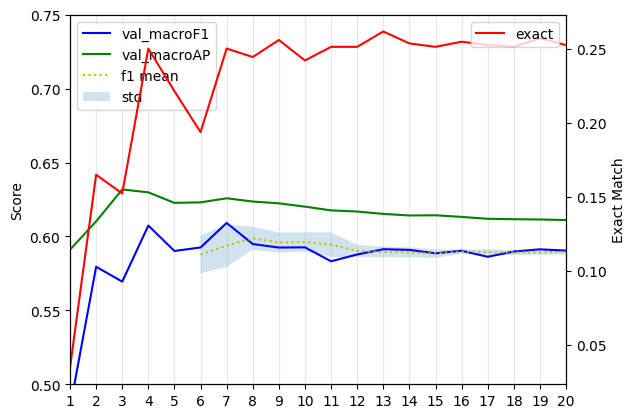

best_score_this_training=0.595 max_score=0.595 current best num_layers=1
num layers=2


'VAL  loss=3.453 exact=0.249 hamming_loss=0.302 microF1=0.698 macroF1=0.573 per_label_f1=[0.262 0.832 0.198 0.906 0.7   0.634 0.657 0.397]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


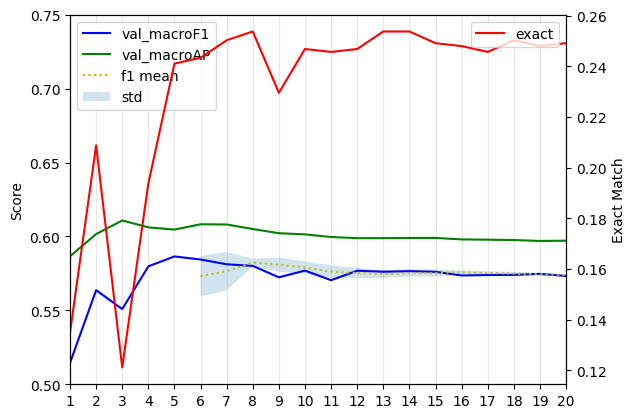

best_score_this_training=0.584 max_score=0.595 current best num_layers=1
num layers=3


'VAL  loss=3.016 exact=0.227 hamming_loss=0.300 microF1=0.700 macroF1=0.571 per_label_f1=[0.262 0.833 0.213 0.91  0.695 0.629 0.677 0.351]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 11


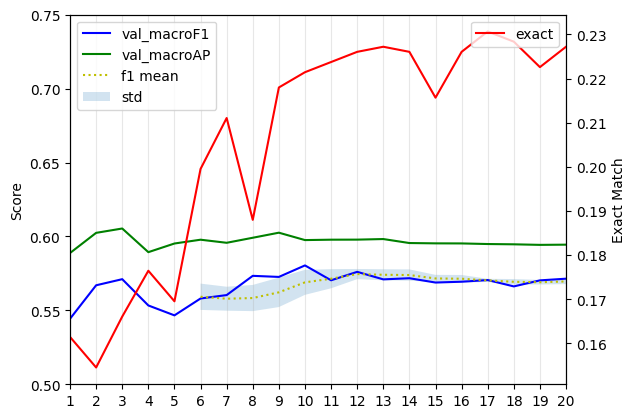

best_score_this_training=0.570 max_score=0.595 current best num_layers=1


In [15]:
# tune num_layers
iterate_num_layers = [1, 2, 3]
max_val  = -np.inf
best_num_layers = -np.inf
for num_layers in iterate_num_layers:
        model = LSTM_MBTI(num_layers=num_layers)
        print(f"\033[31mnum layers={num_layers}\033[0m")
        model, best_score, _ = train(model)
        if best_score > max_val:
                max_val = best_score
                best_num_layers = num_layers
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best num_layers={best_num_layers}\033[0m")

bidirectional=True


'VAL  loss=3.300 exact=0.236 hamming_loss=0.304 microF1=0.696 macroF1=0.580 per_label_f1=[0.304 0.829 0.213 0.904 0.692 0.615 0.663 0.418]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


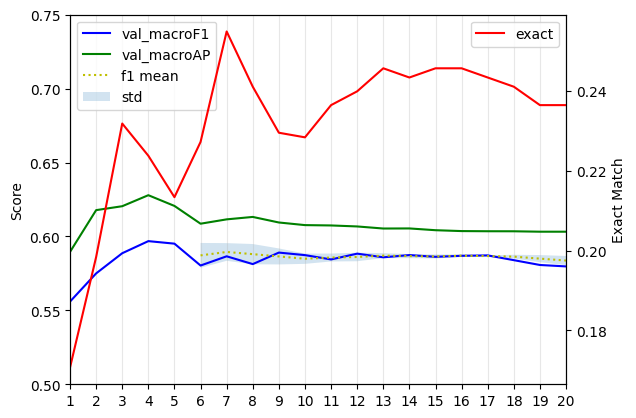

best_score_this_training=0.580 max_score=0.580 Bidirectional=True
bidirectional=False


'VAL  loss=3.144 exact=0.245 hamming_loss=0.307 microF1=0.693 macroF1=0.580 per_label_f1=[0.295 0.824 0.225 0.897 0.708 0.622 0.649 0.424]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 9


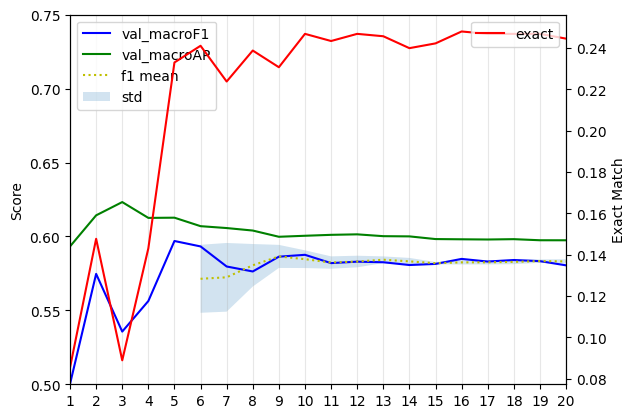

best_score_this_training=0.586 max_score=0.586 Bidirectional=False


In [16]:
# test if bidirectional
iterate_directions = [True, False]
max_val  = -np.inf
best_directions = True
for directions in iterate_directions:
        model = LSTM_MBTI(bidirectional=directions)
        print(f"\033[31mbidirectional={directions}\033[0m")
        model, best_score, _ = train(model)
        if best_score > max_val:
                max_val = best_score
                best_directions = directions
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mBidirectional={best_directions}\033[0m")

embed dim=128


'VAL  loss=2.761 exact=0.230 hamming_loss=0.315 microF1=0.685 macroF1=0.574 per_label_f1=[0.276 0.824 0.225 0.892 0.693 0.61  0.638 0.433]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


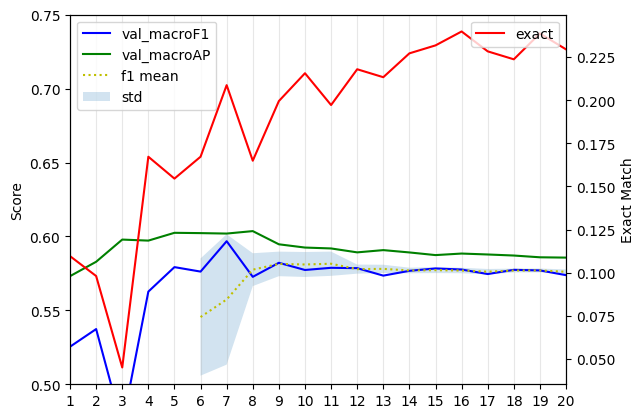

best_score_this_training=0.573 max_score=0.573 current best embed_dim=128
embed dim=256


'VAL  loss=3.129 exact=0.233 hamming_loss=0.313 microF1=0.687 macroF1=0.572 per_label_f1=[0.265 0.822 0.208 0.896 0.686 0.615 0.65  0.434]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 8


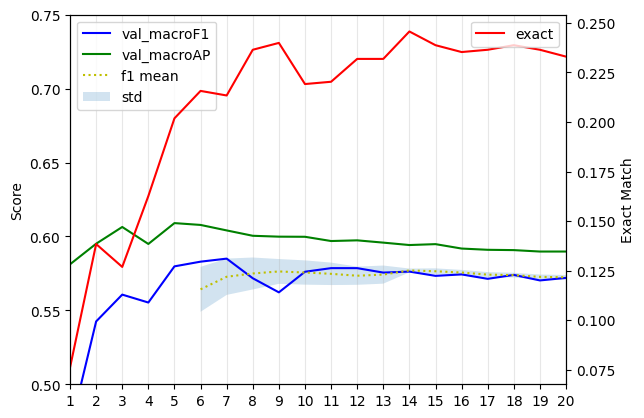

best_score_this_training=0.572 max_score=0.573 current best embed_dim=128
embed dim=384


'VAL  loss=3.063 exact=0.248 hamming_loss=0.310 microF1=0.690 macroF1=0.578 per_label_f1=[0.331 0.824 0.193 0.902 0.707 0.629 0.622 0.416]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 6


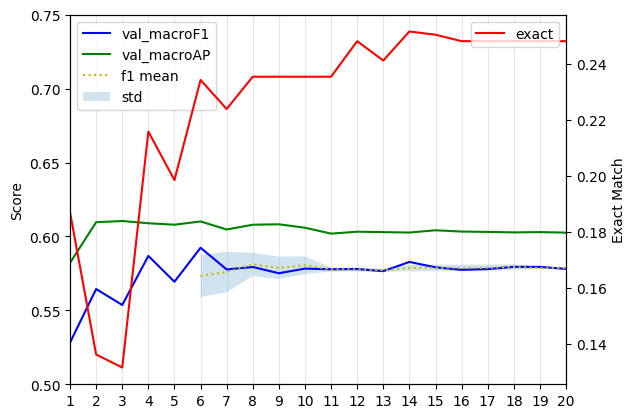

best_score_this_training=0.592 max_score=0.592 current best embed_dim=384
embed dim=512


'VAL  loss=3.172 exact=0.254 hamming_loss=0.295 microF1=0.705 macroF1=0.597 per_label_f1=[0.326 0.829 0.241 0.902 0.725 0.65  0.652 0.452]'

  0%|          | 0/20 [00:00<?, ?it/s]

loaded model from epoch 10


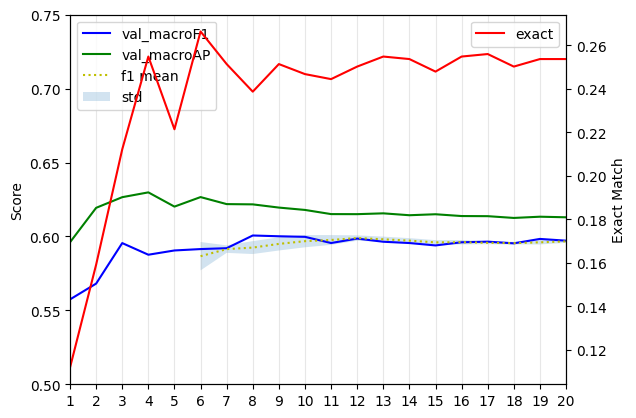

best_score_this_training=0.600 max_score=0.600 current best embed_dim=512


In [17]:
# tune embed_dim
iterate_embed_dim = [128, 256, 384, 512]
max_val  = -np.inf
best_embed_dim = -np.inf
for embed_dim in iterate_embed_dim:
        model = LSTM_MBTI(embed_dim=embed_dim)
        print(f"\033[31membed dim={embed_dim}\033[0m")
        model, best_score, _ = train(model)
        if best_score > max_val:
                max_val = best_score
                best_embed_dim = embed_dim
        print(f"best_score_this_training={best_score:.3f} max_score={max_val:.3f} \033[31mcurrent best embed_dim={best_embed_dim}\033[0m")

Testing

'VAL  loss=1.870 nem=0.663 hamming_loss=0.291 microF1=0.709 macroF1=0.707 per_label_f1=[0.65  0.739 0.699 0.737 0.743 0.766 0.68  0.643]'

  0%|          | 0/20 [00:00<?, ?it/s]

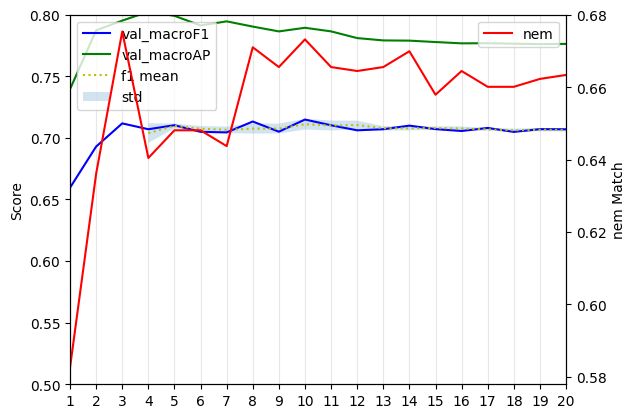

In [61]:
# training
model = LSTM_MBTI()
model, best_score, states = train(model, output=True, save_all_epochs=True)

In [63]:
chosen_epoch = 8
model.load_state_dict(states[chosen_epoch-1])

<All keys matched successfully>

In [64]:
# model eval
val = evaluate(model, cfg_val_loader)
print(f"VAL loss={val["loss"]:.3f} near exact match={val["nem"]:.3f} hamming_loss={val["hamming_loss"]:.3f} "
            f"microF1={val["microF1"]:.3f}\033[31m macroF1={val["macroF1"]:.3f}\033[0m "
            f"per_label_f1={np.round(val["per_label_f1"], 3)}")

test = evaluate(model, cfg_test_loader)
print(f"TEST loss={test["loss"]:.3f} near exact match={test["nem"]:.3f} hamming_loss={test["hamming_loss"]:.3f} "
            f"microF1={test["microF1"]:.3f}\033[31m macroF1={test["macroF1"]:.3f}\033[0m "
            f"per_label_f1={np.round(test["per_label_f1"], 3)}")

VAL loss=1.110 near exact match=0.671 hamming_loss=0.284 microF1=0.716 macroF1=0.713 per_label_f1=[0.645 0.73  0.713 0.745 0.745 0.765 0.708 0.656]
TEST loss=1.089 near exact match=0.666 hamming_loss=0.278 microF1=0.722 macroF1=0.719 per_label_f1=[0.645 0.712 0.719 0.764 0.739 0.758 0.742 0.675]


In [29]:
# save
save_path = str(Path(path).parent / "model.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "tok": tok,
}, save_path)


In [30]:
# load
ckpt = torch.load(str(Path(path).parent / "model.pt"), map_location="cuda", weights_only=False)

model = LSTM_MBTI()
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

thresholds = ckpt.get("thresholds")
tok = ckpt.get("tok")


In [23]:
# tokenize input
def tokenize_text(text, tokenizer):
    text = regex.sub(r"http[^\s|]+", " __url__ ", text)
    text = text.replace("|||", " __sep__ ")
    text = regex.sub(r"(?i)\b[IE][NS][TF][JP]\b", " __tar__ ", text)
    text = regex.sub(r"\s+", " ", text)
    rx = regex.compile(r"[^_\p{White_Space}\p{scx=Latin}\p{Emoji}]+")
    text = rx.sub("", text)
    
    return tokenizer.encode(text)

In [24]:
# predict
zero_out = ["E", "S", "F", "P"]
one_out = ["I", "N", "T", "J"]
def predict(model, tokenized_text):
    model = model.to(device)
    model.eval()
    data = torch.tensor(tokenized_text.ids, dtype=torch.long).unsqueeze(0)
    data = data.to(device)
    with torch.no_grad():
        out = model(data).cpu()
    probs = torch.softmax(out, 2)
    print(np.round(probs, 3))
    bits = probs.argmax(dim=-1)
    mbti = "".join(one_out[i] if bits[0, i].item() == 1 else zero_out[i] for i in range(4))
    
    return mbti

In [26]:
# input
text = "I see some guy sitting in the gym and he wants to grab his phone and don’t get it because he has 26 kg weights on his legs and I sit there and thinking to give him his phone that he can switches music but then he find a good song.  It was a very good workout. I am so excited for spring and ’m walking around a little walk and enjoying the evening and then I go and shower. ||| You don’t have given me any feedback for my new playlists yet |||  think that this is the key of a good conversation ||| No it’s called Thuringia ||| Hahah no I walked not here it was on the way back home i stoped in the middle of the way back ||| That’s very sad now I actually feel a little bit bad ||| I think it’s based of the thinking of the most people in small towns they are satisfied with the way the life an the things they are surrounded by and if anything changes they are critical and think it’s mostly something bad.  ||| And I think that’s why it ist so important that Lucien and I take the chance to study in Munich because we met so many people with other opinions and experiences that you learn that’s not always as good as you think if everything stays the same ||| I can see it by my old friends from my hometown they all have the same perspective and political beliefs and I think it’s because they are all living at home by their parents and don’t have the force to build their own lives with their responsibility to make their own experiences and opinions about things ||| I think I like to take the lead but I love like a protagonist because it’s not good for me to lead relationships ||| And I’m learning to observe before I do something and give other the chance to do it and take the responsibility ||| I like this language besides the schoolwork because ist teaches you to write some essays but not how to use it in your everyday life and that’s sad because I think more people would like to learn it if it’s not in that context"
tokens = tokenize_text(text, tok)
out = predict(model, tokens)
print(out)

tensor([[[0.0730, 0.9270],
         [0.0080, 0.9920],
         [0.5020, 0.4980],
         [0.4960, 0.5040]]])
INFJ
